# Notes on GRASP

Applied to the Symmetric TSP.

Implementations:
* **Basic (PURE) GRASP** Fixed RCL size + Hill Climbing (First Improvement) local search (with 2Opt Tweaks).
    * Variation 1: **Short term memory/tabu list** for constructor.
    * Variation 2: **Probablistic selection of RCL size.**
    * Variation 3: **Reactive GRASP.**
    * Variation 4: **Random Plus Greedy**
    * **Pick and Mix**
* **Elite Sets**
    * Example function implementing long term memory aiming to max performance and diversity.

> **Notes**: A bit of the metapy frameworks including `HillClimber` needs refactoring to make switching between max/min problems simpler.  It works here no problem, but is confusing if you look at the code!

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
import metapy.tsp.tsp_io as io
import metapy.tsp.euclidean as e
from metapy.tsp.objective import SimpleTSPObjective, OptimisedSimpleTSPObjective
from metapy.local_search.hill_climbing import HillClimber, TweakTwoOpt

In [3]:
#load file
file_path = "data/st70.tsp"

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)

#read the meta data
meta = io.read_meta_data(file_path, md_rows)

#should be an numpy.ndarray
print(type(cities))

# should be 70 cities
print(cities.shape)

#print first 2 coordinate pairs
print(cities[:2])

print("st70 meta data")
print(meta)

<class 'numpy.ndarray'>
(70, 2)
[[64. 96.]
 [80. 39.]]
st70 meta data
['NAME: st70', 'TYPE: TSP', 'COMMENT: 70-city problem (Smith/Thompson)', 'DIMENSION: 70', 'EDGE_WEIGHT_TYPE : EUC_2D']


In [4]:
from decimal import Decimal, ROUND_HALF_UP

def gen_matrix(cities, as_integer=False):
    """
    Creates a numpy array of euclidian distances between 2 sets of
    cities
    
    Parameters:
    ----------
    points: numpy.array
        coordinate pairs
    
    as_integers: bool, optional (default=False)
        If true then round to nearest int
        Behaviour: 1.5 -> 2
                   1.2 -> 1
                   1.8 -> 2
                   
    Returns:
    -------
        np.ndarray
            Matrix of city to city costs
    
    """
    size = len(cities)
    matrix = np.zeros(shape=(size, size))
    
    row = 0
    col = 0
    
    for city1 in cities:
        col = 0
        for city2 in cities:
            distance = e.euclidean_distance(city1, city2)
            if as_integer:
                distance = int(Decimal(distance).quantize(0, ROUND_HALF_UP))
            matrix[row, col] = distance
            col+=1
        row +=1
        
    return matrix

In [5]:
def plot_tour(tour, cities, figsize=(6,4)):
    '''
    Plots a tour.  Each city visited is
    labelled in order.  Red point is the initial city.
    
    Params:
    ------
    tour: np.ndarray
        ordered vector representing tour e.g. [1, 4, 2, 3]
        
    cities: np.ndarray
        matrix representing city coordinates
        
    figsize: tuple, optional (default = (6,3))
        tuple of ints for figure size
        
    Returns
    -------
        tuple of matplotlib figure, and axis
    '''

    tour_length = len(tour)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    #plot points
    ax.plot(cities[:tour_length][:, 0],
            cities[:tour_length][:, 1],'bo')

    #plot lines
    for j in range(len(tour)-1):
        city_1 = tour[j]
        city_2 = tour[j+1]

        #lookup coordinates
        coords_1 = cities[city_1]
        coords_2 = cities[city_2]
        coords = np.vstack([coords_1, coords_2])

        #plot lines
        ax.plot(coords[:,0], coords[:,1], 'g-')
        
        #show order in tour
        ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(j))

    #add in loop back colour code in red...
    city_1 = tour[-1]
    city_2 = tour[0]

    coords_1 = cities[city_1]
    coords_2 = cities[city_2]
    coords = np.vstack([coords_1, coords_2])
    ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(tour_length-1))
    ax.plot(coords[:,0], coords[:,1], 'r--')
        
    return fig, ax

In [6]:
#generate matrix
TRUNC = 70
trunc_cities = cities[:TRUNC]

matrix = gen_matrix(trunc_cities, as_integer=True)

file_out = 'data/st70_matrix.csv'

#output city matrix - to validate and use for manual calcs etc.
np.savetxt(file_out, matrix, delimiter=",")

In [7]:
#create ordered list of cities to visit
tour = np.arange(TRUNC)
tour

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

In [132]:
class FixedRCLSizer:
    def __init__(self, r):
        self.r = r
        
    def get_size(self):
        return self.r
    
class RandomRCLSizer:
    def __init__(self, r_list, random_seed=None):
        self.r_list = r_list
        self.rng = np.random.default_rng(random_seed)
        
    def get_size(self, size=None):
        return self.rng.choice(self.r_list, size=size)

In [332]:
class SemiGreedyConstructor:
    '''
    Semi-greedy construction of a tour.
    
    For a city i creates a restricted candidate list of size r
    i.e the r shortest distances from city i.  Next city is chosen
    with equal probability.
    Repeats until tour is constructed.
    
    '''
    def __init__(self, rcl_sizer, tour, matrix,
                 random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        rcl_sizer: object
            sizes the restricted candidate list
        
        tour: np.ndarray
            vector of city indexes included in problem
            
        matrix: np.ndarray
            matrix of travel costs
            
        random_seed: int
            used to control sampling and provides a
            reproducible result.
        '''
        
        # size of rcl
        self.rcl_sizer = rcl_sizer
        
        # cities in a tour
        self.tour = tour
        
        # travel cost matrix
        self.matrix = matrix
        
        # create random number generator
        self.rng = np.random.default_rng(random_seed)
    
    def build(self):
        '''
        Semi-greedy contruction of tour
        
        Returns:
        --------
        np.array
        '''
        # first city in tour
        solution = np.array([self.tour[0]])    
        
        for i in range(len(self.tour)-1):
            r = self.rcl_sizer.get_size()
            rcl = self.get_rcl(r, solution, solution[-1])
            next_city = self.random_from_rcl(rcl)
            solution = np.append(solution, np.array([next_city]))
            
        return solution
    
    def get_rcl(self, r, solution, from_city):
        '''
        Restricted candidate list for final city in current solution
        
        Params:
        -------
        solution: np.ndarray
            vector of current partially constructed solution
            
        from_city: int
            index of city used to construct rcl.
        
        Returns:
        -------
        np.array
        '''
        # get indexes of cities not in solution
        mask = self.tour[~np.in1d(self.tour, solution)]
        
        # get indexes of r smallest travels costs 
        if mask.shape[0] > r:
            # partition the vector for remaining cities - faster than sorting 
            idx = np.argpartition(self.matrix[from_city][mask], len(mask) - r)[-r:]
            rcl = mask[idx]
        else:
            # handle when r < n cities remaining 
            rcl = mask
        return rcl
    
    def random_from_rcl(self, rcl):
        '''
        Select a city at random from rcl.
        Return city index in self.matrix
        
        Params:
        -------
        rcl: np.ndarray
            restricted candidate list
            vector of candidate city indexes.
        '''
        return self.rng.choice(rcl)
        

In [345]:
# when r = 1 then greedy.  
# when r = len(tour) then random solution

sizer = FixedRCLSizer(r=2)
constructor = SemiGreedyConstructor(sizer, tour, -matrix)
constructor.build()

array([ 0, 35, 28, 69, 30, 12, 68, 37, 58, 62, 65, 21, 56, 14, 18,  6,  1,
        3, 17, 41, 40,  5, 16, 20, 33, 11, 32, 53, 47, 10, 66, 64, 50, 55,
       51,  9, 49, 57, 46, 15, 22, 36,  4, 52, 42, 67, 43, 29, 13, 27, 25,
        7,  2, 19, 31, 48, 23, 34, 54, 26, 39, 60, 38, 44, 24,  8, 61, 59,
       63, 45])

In [346]:
# alternative setup with random sizer
# pass RandomRCLSizer a list or np.array of ints of r.
sizer = RandomRCLSizer(np.arange(1, 15))
constructor = SemiGreedyConstructor(sizer, tour, -matrix)
constructor.build()

array([ 0, 30, 37, 65, 52,  9, 36, 46, 57, 21, 68, 35, 22, 56, 14, 62,  3,
       25, 54, 18,  2, 40, 43, 67,  8, 45, 24, 61, 11, 20, 66, 32, 53, 33,
       59, 51, 64, 47, 55, 50, 41,  6, 31, 23, 17,  5, 27, 29, 26, 39, 16,
        4, 15, 12, 63, 49, 10, 38, 42, 60, 69,  7, 19, 34, 48, 13, 28, 58,
       44,  1])

In [347]:
class NullLocalSearch:
    '''
    Null pattern. Used to 'turn off' the local search
    in algorithms like GRASP that mandate ls logic.
    '''
    def __init__(self, objective):
        '''
        Constructor
        
        Params:
        ------
        objective: TSP Objective object
            evaluates a solution
        '''
        self.obj = objective
        self.init_solution = None
        self.best_cost = -np.inf
        self.best_solution = None
        
    def set_init_solution(self, solution):
        '''
        Set the initial solution of the local search
        
        Params:
        ------
        solution: np.ndarray
            initial solution represented as a vector of
            city indexes
        '''
        self.best_solutions = [solution]
        self.best_cost = obj.evaluate(solution)
        
    def solve(self):
        '''
        Solve the TSP... 
        Null does not execute any logic
        '''
        pass
        

In [348]:
class GRASP:
    '''
    Greedy Randomised Adaptive Search Procedure algorithm
    for the Travelling Salesman Problem
    
    '''
    def __init__(self, constructor, local_search, max_iter=1000,
                 time_limit=np.inf):
        
        # semi greedy tour construction method
        self.constructor = constructor
        
        # local search procedure
        self.local_search = local_search
        
        # max runtime budget for GRASP
        self.max_iter = max_iter
        self.time_limit = time_limit
        
        # init solution 
        self.best_solution = None
        self.best = None
    
        
    def solve(self):
        '''
        Run GRASP
        
        Returns:
        -------
        None
        '''
        
        self.best_solution = None
        self.best = -np.inf
        
        i = 0
        start = time.time()
        while i < self.max_iter and ((time.time() - start) < self.time_limit):
            
            i += 1
            
            # construction phase
            solution = self.constructor.build()
            
            # Improve solution via local search
            self.local_search.set_init_solution(solution)
            self.local_search.solve()
            
            current_solution = self.local_search.best_solutions
            current_solution = current_solution[0]
            current = self.local_search.best_cost
            # check if better than current solution
            if current > self.best:
                self.best = current
                self.best_solution = current_solution

## Script 1: **Basic GRASP**; Fixed RCL size; Hill Climbing

**size of RCL is fixed**


Running GRASP.

** GRASP OUTPUT ***
best cost:	-745.0
best solutions:
[ 0 35 28 12 69 30 68 34 58 37 22 15 46 36 57 49  4 52 65 21 62 56 14 23
 18 54 48 25  7 27 13 19 29 26 45 44 24 38 60 39  8 67 43  2 31  6  1  3
 17 41  5 40 42 16 20 33 11 59 51  9 50 64 55 10 66 47 53 61 32 63]
CPU times: user 7.72 s, sys: 38.7 ms, total: 7.76 s
Wall time: 7.81 s


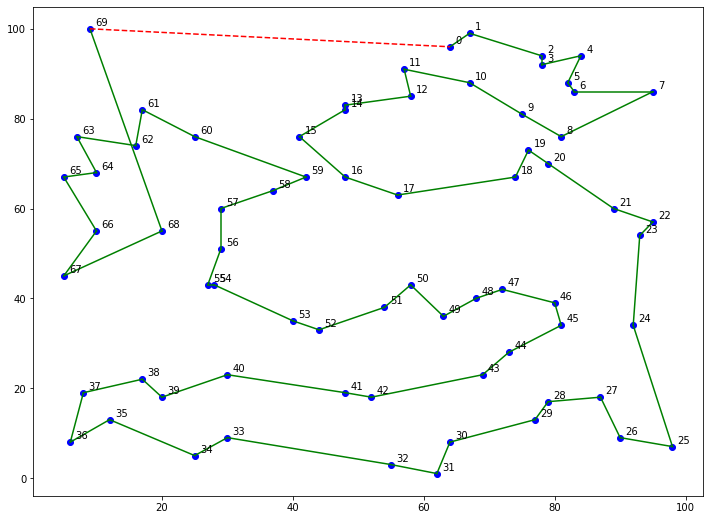

In [350]:
%%time 
# objective function; optimised = numpy
# not this calculates cost of full tour
# doesn't consider gain or hash solution:cost to increase efficiency
obj = OptimisedSimpleTSPObjective(-matrix)

# Two-opt tweaks
tweaker = TweakTwoOpt(random_seed=None)

# local search = first improvement hill climbing
ls = HillClimber(obj, tour, tweaker)

# semi-greedy constructor and RCL sizer
sizer = FixedRCLSizer(r=5)
constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)

# bring ingredients together in the GRASP framework
solver = GRASP(constructor, ls, max_iter=50)

print("\nRunning GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## Variation 1: Short term memory in the construction phase.

In [ ]:
class ConstructorWithMemory:
    '''
    Provides a construction heuristic with a short term memory
    '''
    def __init__(self, constructor, memory_size=100):
        '''Constructor method
        
        Params:
        -------
        constructor: Object
            Implements build() and returns a solution
            
        memory_size, int, optional (default=100)
            size of tabu list
        '''
        self.constructor = constructor
        self.memory_size = memory_size
        # memory implemented as list
        self.history = []
        
    def build(self):
        '''
        Run the stochastic construction heuristic
        
        Re-runs heuristic if results is within memory
        
        Returns:
        --------
        np.ndarray
        '''
        solution = self.constructor.build()
        while str(solution) in self.history:
            solution = self.constructor.build()
        
        # if at capacity remove oldest solution
        if len(self.history) >= self.memory_size: 
            self.history.pop(0)
        
        self.history.append(str(solution))
        return solution


Running GRASP.

** GRASP OUTPUT ***
best cost:	-722.0
best solutions:
[ 0 15 46 36 57 49  4 52  5 40 42 16 20 33 11 51  9 50 64 63 10 47 66 55
 59 32 53 61 38 24 44 60 39 45 26  8 67 43 29 19 13 27  7  2 31 41 17  3
  1  6 25 48 54 18 23 14 56 62 65 21 58 34 68 30 69 12 37 22 28 35]
CPU times: user 8.4 s, sys: 65 ms, total: 8.46 s
Wall time: 8.55 s


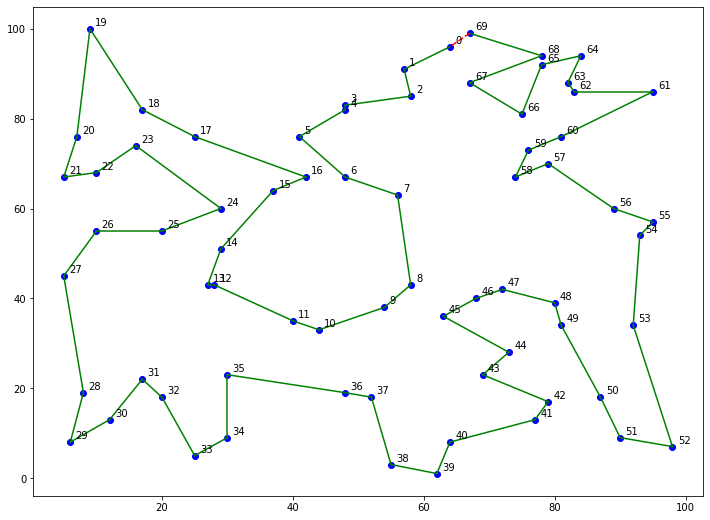

In [355]:
%%time 
# objective function
obj = OptimisedSimpleTSPObjective(-matrix)

# Two-opt tweaks
tweaker = TweakTwoOpt(random_seed=None)

# local search = first improvement hill climbing
ls = HillClimber(obj, tour, tweaker)

# semi-greedy constructor and RCL sizer
sizer = FixedRCLSizer(r=5)
constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)
# add memory to constructor
constructor = ConstructorWithMemory(constructor)

# bring ingredients together in the GRASP framework
solver = GRASP(constructor, ls, max_iter=50)

print("\nRunning GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## Variation 3: **probabilistic selection of RCL size**

In general, the increased exploration from randomly selecting the RCL length should lead to better solutions.  This may be at the cost of slightly increased run time i.e. might be better to run with a `max_iter` than `time_limit` when comparing with a fixed sized RCL.


Running Random GRASP.

** GRASP OUTPUT ***
best cost:	-757.0
best solutions:
[ 0 35 28 69 34 58 21 62 56 14 23 65 52  4  9 51 59 11 33 20 16 42 40  5
 41 17  3  1  6 31  2 27  7 25 18 54 48 13 19 29 43 67  8 26 45 39 44 24
 38 60 61 53 32 66 47 10 55 63 64 50 49 46 22 37 68 30 12 15 36 57]


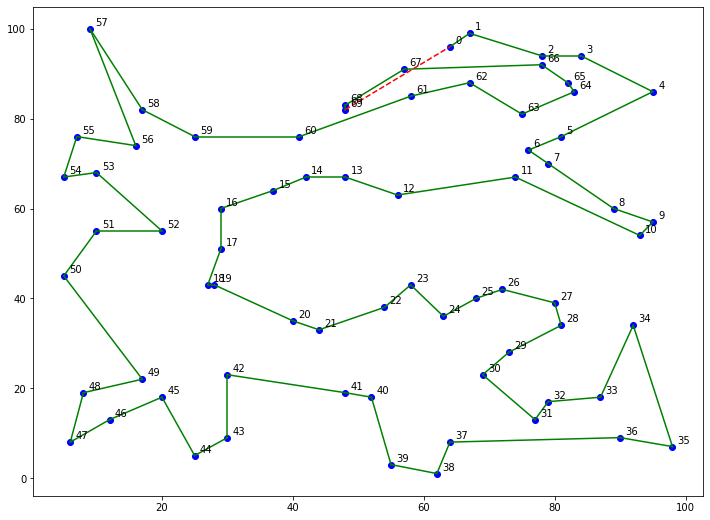

In [294]:
RCL_MIN = 2
RCL_MAX = 15

# objective function
obj = OptimisedSimpleTSPObjective(-matrix)

# Two-opt tweaks
tweaker = TweakTwoOpt(random_seed=None)

# local search = first improvement hill climbing
ls = HillClimber(obj, tour, tweaker)

# semi-greedy constructor and RCL sizer
sizer = RandomRCLSizer(np.arange(RCL_MIN, RCL_MAX), random_seed=None)
constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)

# GRASP framework
solver = GRASP(constructor, ls, max_iter=50)

print("\nRunning Random GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

# Script excluding local search

**Should confirm that semi-greedy solutions are suboptimal**


Running GRASP.

** GRASP OUTPUT ***
best cost:	-1426.0
best solutions:
[ 0 35 22 28 69 37 21 65 58 62 68 15 57  4 52 46 30 34 12 56 23  3  6 31
  7 13 19 29 27 43 41  2 17  1 40  5  9 51 32 59 50 66 53 10 64 63 49 11
 20 33 60 44 38 24 61 39 26 45  8 47 67 42 36 55 16 14 48 18 54 25]


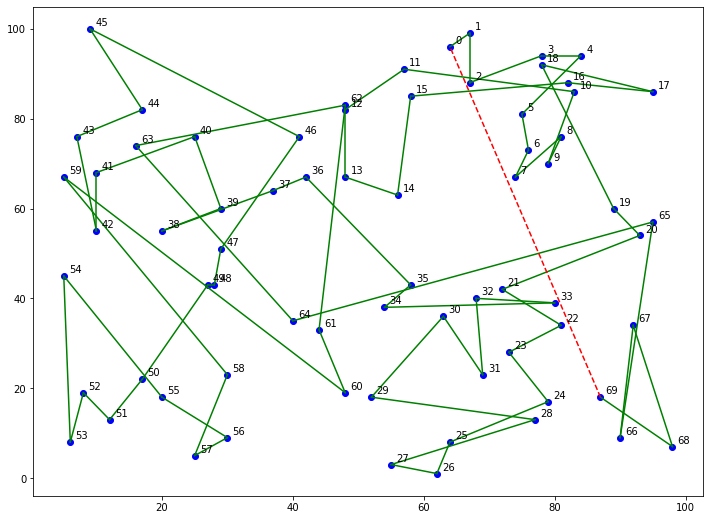

In [167]:
RCL_SIZE = 5

obj = OptimisedSimpleTSPObjective(-matrix)
ls = NullLocalSearch(obj)
# semi-greedy constructor and RCL sizer
sizer = FixedRCLSizer(r=RCL_SIZE)
constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)
solver = GRASP(constructor, ls, max_iter=50)
print("\nRunning GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

# Reactive GRASP

In reactive GRASP the probability of selecting a RCL size is proportional to historical performance of this RCL size.

Let $q_i = f^* / A_i$
and $p_i = \dfrac{q_i}{\sum_{j=1}^{m} q_j}$
        
where

$f^*$ is the incumbent (best cost); 
$A_i$ is the mean cost found with $r_i$

larger $q_i$ indicates more suitable values of $r_i$

To implement we create two new classes:

* `MonitoredLocalSearch` - wraps HillClimber and notifies observering classes when a GRASP local search phase is complete.
* `ReactiveRCLSizer` - observes GRASP local search, tracks average performance of RCL sizes, and updates prob of choosing different r's at a user specified frequency.

In [204]:
class MonitoredLocalSearch:
    '''
    Extends a local search class and provides the observer pattern.
    An external object can observe the local search object and catch the
    termination event (end of local search).  The observer is notified and
    passed the results of the local search.

    Use cases: 
    ----------
    In GRASP this is useful for an algorithm sizing the RCL and learning 
    on average how different sizes of RCL perform.
    '''
    def __init__(self, local_search):
        '''
        Constructor:
        
        Params:
        ------
        local_search: Object
            Must implement .solve(), best_cost, best_solution
        '''
        self.local_search = local_search
        self.observers = []
    
    def register_observer(self, observer):
        '''
        register an object to observe the local search
        
        The observer should implement 
        local_search_terminated(*args, **kwargs)
        '''
        self.observers.append(observer)
        
    def set_init_solution(self, solution):
        '''
        Set the initial solution
        
        Params:
        --------
        solution: np.ndarray
            vector representing the initial solution
        '''
        self.local_search.set_init_solution(solution)
    
    def solve(self):
        '''
        Run the local search.  
        At the end of the run all observers are notified.
        '''    
        # run local search
        self.local_search.solve()
        
        # notify observers after search terminates.
        best = self.local_search.best_cost
        solution = self.local_search.best_solutions[0]
        self.notify_observers(best, solution)
        
    
    def notify_observers(self, *args, **kwargs):
        '''
        Observers must implement `local_search_terminated()`
        method.
        
        Params:
        ------
        *args: list
            variable number of arguments
            
        **kwargs: dict
            key word arguments
        '''
        for o in self.observers:
            o.local_search_terminated(*args, **kwargs)
    
    def _get_best_cost(self):
        '''
        best cost from internal local_search object
        '''
        return self.local_search.best_cost
    
    def _get_best_solutions(self):
        '''
        get best solutions from local_search object
        '''
        return self.local_search.best_solutions
    
    best_cost = property(_get_best_cost, doc='best cost')
    best_solutions = property(_get_best_solutions, doc='best solution')
        

In [286]:
class ReactiveRCLSizer:
    '''
    Dynamically update the probability of selecting a 
    value of r for the size of the RCL.
    
    Implements Reactive GRASP.
    
    '''
    def __init__(self, r_list, local_search, freq=None, random_seed=None):
        '''
        Constructor
        
        Params:
        -------
        r_list: list
            vector of sizes for RCL e.g. [1, 2, 3, 4, 5]
            
        local_search: MonitoredLocalSearch
            local_search to monitor
            
        freq: int, optional (default=None)
            Frequency in iterations at which the probabilities are updated.
            When set to None it defaults to the length of r_list * 2
            
        random_seed: int, optional (default=None)
            Control random sampling for reproducible result
        '''
        # list of r sizes
        self.r_list = r_list
        
        # set of indexes to work with probabilities
        self.elements = np.arange(len(r_list))
    
        # probability of choosing r (initially uniform)
        self.probs = np.full(len(r_list), 1/len(r_list))
        
        # mean performance of size r
        self.means = np.full(len(r_list), 1.0)
        
        # runs of size r
        self.allocations = np.full(len(r_list), 0)
        
        # local search to monitor
        self.local_search = local_search
        
        # frequency of updating probs
        if freq is None:
            self.freq = len(self.r_list)
        else:
            self.freq = freq
        
        # number of iterations within frequency
        self.iter = 0
        
        # current r index
        self.index = -1
        
        # to init run one of each r value
        self.init = True
        
        # imcumbent solution cost
        self.best_cost = -np.inf
        
        # register sizer as observer of the local search
        local_search.register_observer(self)
        
        # random no. gen
        self.rng = np.random.default_rng(random_seed)
    
    def local_search_terminated(self, *args, **kwargs):
        '''
        Termination of the local search
        '''
        # iteration complete
        self.iter += 1
        
        # get the best cost found in the iteration
        iter_cost = args[0]

        # record iteration took plaxe with index i
        self.allocations[self.index] += 1
        
        # update running mean
        mean_x = self.means[self.index]
        n = self.allocations[self.index]
        self.means[self.index] += (iter_cost - mean_x) / n
        
        self.update_r()
        
        # update incumbent cost if required
        if iter_cost > self.best_cost:
            self.best_cost = iter_cost
        
        # update probs if freq met.
        if self.iter >= self.freq and not self.init:
            self.iter = 0
            self.update_probability()
            
        
    def update_probability(self):
        '''
        Let $q_i = f^* / A_i$
        and $p_i = `\dfrac{q_i}{\sum_{j=1}^{m} q_j}$
        
        where
        
        $f^*$ is the incumbent (cost)
        $A_i$ is the mean cost found with r_i
        
        larger q_i indicates more suitable values of r_i
        '''
        q = self.best_cost / self.means
        self.probs = q / q.sum()
    
    def update_r(self):
        '''
        update the size of r
        
        Note that the implementation ensures that all r values are run
        for at least one iteration of the algorithm.
        '''
        # initial bit of logic makes sure there is at least one run of all probabilities
        if self.init:
            self.index += 1
            if self.index >= len(self.r_list):
                self.init = False
                self.index = self.rng.choice(self.elements, p=self.probs)
        else:
            self.index = self.rng.choice(self.elements, p=self.probs)
    
    def get_size(self):
        '''
        Return the selected size of the RCL
        
        The selection is done using a discrete distribution
        self.r_probs.
        '''
        return self.r_list[self.index]
       


Running REACTIVE GRASP.

** GRASP OUTPUT ***
best cost:	-742.0
best solutions:
[ 0 35 28 12 69 30 68 34 58 37 22 15 46 36 57  4 52 65 21 62 56 14 23 18
 25 54 48 27  7 31  6  1  3 17  5 40 41  2 13 19 29 43 67 26 45 24 44 38
 60 39  8 42 16 20 33 11 32 59 51  9 49 50 64 55 66 53 61 47 10 63]
RCL size allocations: [5 3 2 4 5 3 2 2 2 3 8 7 4]
RCL size means: [-802.4        -880.66666667 -855.5        -839.         -832.8
 -833.66666667 -861.5        -808.5        -854.5        -815.
 -816.         -818.71428571 -822.25      ]


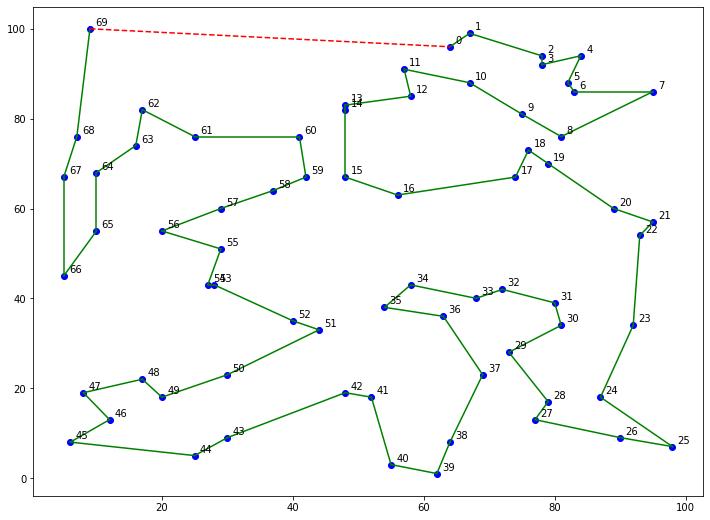

In [293]:
RCL_MIN = 2
RCL_MAX = 15

# objective function
obj = OptimisedSimpleTSPObjective(-matrix)

# Two-opt tweaks
tweaker = TweakTwoOpt(random_seed=None)

# local search = first improvement hill climbing
ls = MonitoredLocalSearch(HillClimber(obj, tour, tweaker))

# semi-greedy constructor and RCL sizer
sizer = ReactiveRCLSizer(np.arange(RCL_MIN, RCL_MAX), ls, freq=10, random_seed=None)
constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)

# GRASP framework
solver = GRASP(constructor, ls, max_iter=50)

print("\nRunning REACTIVE GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
print(f'RCL size allocations: {sizer.allocations}')
print(f'RCL size means: {sizer.means}')
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## Variation 4: Random - Greedy

In [374]:
class RandomPlusGreedyConstructor(SemiGreedyConstructor):
    '''
    Random + semi-greedy construction of a tour.
    
    The first n cities of a tour are randomly constructed.  
    The remaining cities are seleted using the standard semi-greedy approach.
    
    For a city i creates a restricted candidate list of size r
    i.e the r shortest distances from city i.  Next city is chosen
    with equal probability. 
    
    Repeats until tour is constructed.
    
    '''
    def __init__(self, rcl_sizer, tour, matrix, p_rand=0.2,
                 random_seed=None):
        '''
        RandomPlusGreedy Constructor method
        
        Params:
        ------
        rcl_sizer: object
            sizes the restricted candidate list
        
        tour: np.ndarray
            vector of city indexes included in problem
            
        matrix: np.ndarray
            matrix of travel costs
            
        p_rand: float, optional (default=0.2)
            Proportion of tour that is randomly constructed
            
        random_seed: int
            used to control sampling provides a
            reproducible result.
        '''
        
        # super class init
        super().__init__(rcl_sizer, tour, matrix,
                       random_seed)
        
        # proportion of tour that is randomly constructed
        self.p_rand = p_rand
        self.n_rand = int(p_rand * len(tour))
        self.n_greedy = len(tour) - self.n_rand - 1
        
    
    def build(self):
        '''
        Random followed by semi-greedy contruction of tour
        
        Returns:
        --------
        np.array
        '''
        # first city in tour
        solution = np.array([self.tour[0]])    
        # next n_rand cities are random
        rand = self.rng.choice(self.tour[1:], size=self.n_rand, replace=False)
        solution = np.append(solution, rand)
        
        # remaining cities are semi-greedy
        for i in range(self.n_greedy):
            r = self.rcl_sizer.get_size()
            rcl = self.get_rcl(r, solution, solution[-1])
            next_city = self.random_from_rcl(rcl)
            solution = np.append(solution, np.array([next_city]))
            
        return solution        


Running GRASP.

** GRASP OUTPUT ***
best cost:	-736.0
best solutions:
[ 0 35 28 12 69 30 68 34 58 21 65 62 56 14 23  1  6 18 54 48 25  7 27  2
 31  3 17 41  5 40 67 43 13 19 29 26 45 24 44 38 60 39  8 42 16 20 33 11
 32 61 53 47 66 55 10 63 64 50 59 51  9 49 57 36 15 22 37 46 52  4]
CPU times: user 9 s, sys: 66.6 ms, total: 9.06 s
Wall time: 9.18 s


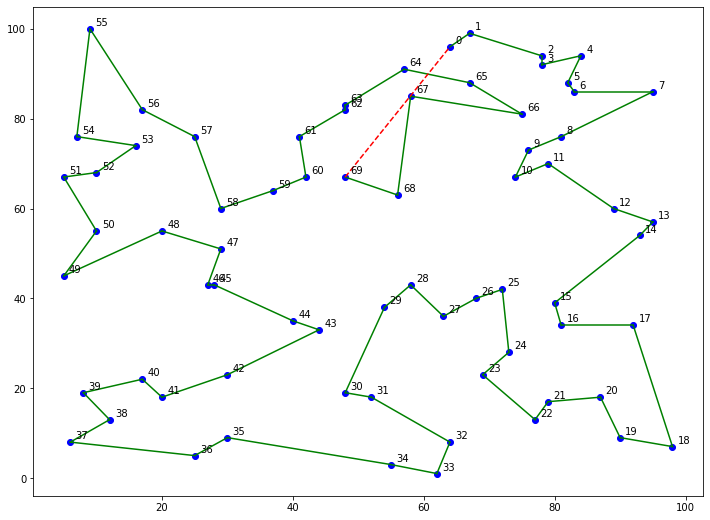

In [375]:
%%time 
# objective function; optimised = numpy
# not this calculates cost of full tour
# doesn't consider gain or hash solution:cost to increase efficiency
obj = OptimisedSimpleTSPObjective(-matrix)

# Two-opt tweaks
tweaker = TweakTwoOpt(random_seed=None)

# local search = first improvement hill climbing
ls = HillClimber(obj, tour, tweaker)

# semi-greedy constructor and RCL sizer
sizer = FixedRCLSizer(r=5)
constructor = RandomPlusGreedyConstructor(sizer, tour, -matrix, p_rand=0.2, random_seed=None)

# bring ingredients together in the GRASP framework
solver = GRASP(constructor, ls, max_iter=50)

print("\nRunning Random Plus Greedy GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## Pick and mix


Running Pick and Mix GRASP.

** GRASP OUTPUT ***
best cost:	-696.0
best solutions:
[ 0 35 15 46 36 57 49 50 55 64 63 10 47 66 53 61 33 20 11 32 59 51  9  4
 52  5 40 42 16  8 39 60 38 24 44 45 26 67 43 29 19 13 48 54 25  7 27  2
 31 41 17  3  1  6 18 23 14 56 62 65 21 22 37 58 34 68 30 69 12 28]


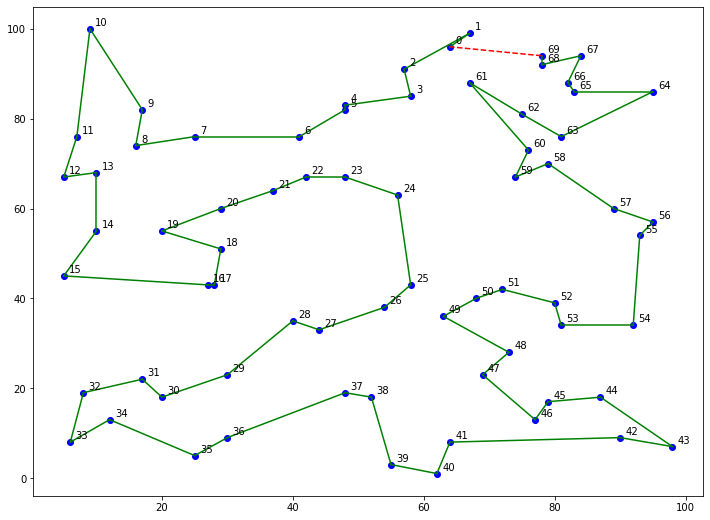

In [380]:
RCL_MIN = 2
RCL_MAX = 15

# objective function
obj = OptimisedSimpleTSPObjective(-matrix)

# Two-opt tweaks
tweaker = TweakTwoOpt(random_seed=None)

# local search = first improvement hill climbing
ls = HillClimber(obj, tour, tweaker)

# semi-greedy constructor and RCL sizer
sizer = RandomRCLSizer(np.arange(RCL_MIN, RCL_MAX), random_seed=None)
constructor = RandomPlusGreedyConstructor(sizer, tour, -matrix, p_rand=0.2, random_seed=None)
# add memory to constructor
constructor = ConstructorWithMemory(constructor)

# GRASP framework
solver = GRASP(constructor, ls, max_iter=50)

print("\nRunning Pick and Mix GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## **Elite Sets**

> These are just notes on how to create a TSP type elite set based on differences in tour and better performance than the worst case. But actually I think this would work similar if problem were binary integer.  For a set covering problem then would need to look at a tweaked implementation looking at symmetric differences between sets.

In [562]:
def update_elite_set(s, s_cost, elite_set=None, elite_costs=None, max_size=2, 
                     min_delta=0):
    '''
    Function to illustrate updating an elite set to maximise
    performance and diversity
    
    Params:
    -------
    s: np.ndarray
        TSP tour
        
    s_cost: float
        TSP tour cost
        
    elite_set: np.ndarray
        matrix of tours in elite set 
        
    elite_costs: np.ndarray
        vector of costs associate with each tour in elite set
        
    max_size:
        maximum entries in the elite set
        
    min_delta: int, optional (Default=0)
        The min cardinality difference between tours to allow entry
        E.g. a = [1, 2, 3, 4, 5]; b = [1, 3, 4, 2, 5]. delta = 3.
        Vary delta > 0 to increase diversity (but mauy limit entry)
        
    Returns:
    -------
    Tuple: np.ndarray, np.ndarray
        elite_set, elite_costs
        
    
    Example usage:
    --------------
    ```python
    >>  x = np.array([1, 2, 3, 4, 6, 7, 8])
    >> y = np.array([1, 4, 2, 6, 7, 3, 8])
    >> z = np.array([1, 5, 2, 6, 8, 3, 7])

    >> elite_set, elite_costs = update_elite_set(x, 10)
    >> elite_set, elite_costs = update_elite_set(y, 20, elite_set, elite_costs, max_size=2)
    >> print(elite_set)
    
    [[1 2 3 4 6 7 8]
     [1 4 2 6 7 3 8]]

    >> elite_set, elite_costs = update_elite_set(z, 15, elite_set, elite_costs, max_size=2)
    >> print(elite_set)
    
    [[1 5 2 6 8 3 7]
     [1 4 2 6 7 3 8]]
    ```
    '''
    
    if elite_set is None:
        # initalise elite_set
        elite_set = np.array([s])
        elite_costs = np.array([s_cost])
        return elite_set, elite_costs
        
    elif len(elite_set) < max_size:
        delta = (s != elite_set).sum(axis=1).min()
        if delta > min_delta:
            elite_set = np.append(elite_set, [s], axis=0)
            elite_costs = np.append(elite_costs, [s_cost], axis=0)
    else:
        # aim to increase performance and diversity of elite set
        worst_cost = elite_costs.min()
        delta = (s != elite_set).sum(axis=1).min()
        
        if s_cost > worst_cost and delta > min_delta:
            replace_idx = elite_costs.argmin()
            elite_set[replace_idx] = s
            elite_costs[replace_idx] = s_cost
            
    return elite_set, elite_costs

In [564]:
# example script
x = np.array([1, 2, 3, 4, 6, 7, 8])
y = np.array([1, 4, 2, 6, 7, 3, 8])
z = np.array([1, 5, 2, 6, 8, 3, 7])

elite_set, elite_costs = update_elite_set(x, 10)
elite_set, elite_costs = update_elite_set(y, 20, elite_set, elite_costs, max_size=2)
print(elite_set)

elite_set, elite_costs = update_elite_set(z, 15, elite_set, elite_costs, max_size=2)
print(elite_set)

[[1 2 3 4 6 7 8]
 [1 4 2 6 7 3 8]]
[[1 5 2 6 8 3 7]
 [1 4 2 6 7 3 8]]
